In [31]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [32]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)

#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)


In [33]:
# Convert date column
df['Expiration_Date'] = pd.to_datetime(df['Expiration Date'], format='%d%b%y')

### Black-Scholes model

* Stock Price (S): In cryptocurrency, this would be the current price of the crypto asset.

* Strike Price (K): The price at which the option can be exercised.

* Time to Expiration (T): The remaining life of the option, usually in years.

* Risk-free Rate (r): The rate of return on a risk-free investment, typically treasury bills.

* Volatility (σ): This is where most adjustments for cryptocurrencies will be made, reflecting the asset's price variability.

example

In [34]:
import numpy as np
from scipy.stats import norm

# Parameters
S = 59330.12  # current BTC price
K = 35000     # strike price
T = 0.25      # time to maturity in years
r = 0.01      # risk-free rate
sigma = 1.20  # adjusted annual volatility

# Black-Scholes formulas
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price is: ${call_price:.2f}")


The adjusted Black-Scholes call price is: $27166.22


In [35]:
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Assuming you've loaded your dataset into a DataFrame named `df`
# For this example, let's select one option to price, e.g., the first row in the dataset
option_data = df.iloc[20]

# Parameters extraction
S = option_data['underlying_price']  # Current price of the underlying asset
K = option_data['Strike Price']      # Strike price of the option
# Adjust the date format to match '3MAY24' which is 'd%b%y' without day leading zero and all-caps month
T = (datetime.strptime(option_data['Expiration Date'], '%d%b%y') - datetime.now()).days / 365.25  # Time to maturity in years
r = 0.01  # Assuming a risk-free rate of 1%
sigma = option_data['mark_iv'] / 100  # Implied volatility from the market data

# Adjusting volatility for crypto-specific factors
sigma *= 1.5  # Adjusting by 50% to account for higher volatility

# Black-Scholes formula for call option
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price for the selected option is: ${call_price:.2f}")


The adjusted Black-Scholes call price for the selected option is: $nan


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\3153892223.py:21: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\3153892223.py:22: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


In [36]:
# Convert Expiration Date to datetime and calculate Time to Expiration in years
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Time to Expiration'] = (df['Expiration Date'] - pd.Timestamp.now()).dt.days / 365

# Use average implied volatility or calculate it if not directly provided
df['Implied Volatility'] = (df['bid_iv'] + df['ask_iv']) / 2 / 100  # converting percentage to decimal


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\434982000.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])


In [37]:
# Example: Using a simple moving average for volatility
df['SMA Volatility'] = df['Implied Volatility'].rolling(window=30).mean()  # 30-day simple moving average


In [38]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """ Calculate the Black-Scholes option price for a call option """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Risk-free rate - As crypto does not have a clear risk-free rate, you may use a proxy like U.S. Treasury rates or a stablecoin yield
risk_free_rate = 0.02  # 2%


In [39]:
# Apply the model to each option in the dataframe
df['BS Price'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['Implied Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [40]:
# Apply the model to each option in the dataframe
df['BS Price_1'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['SMA Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


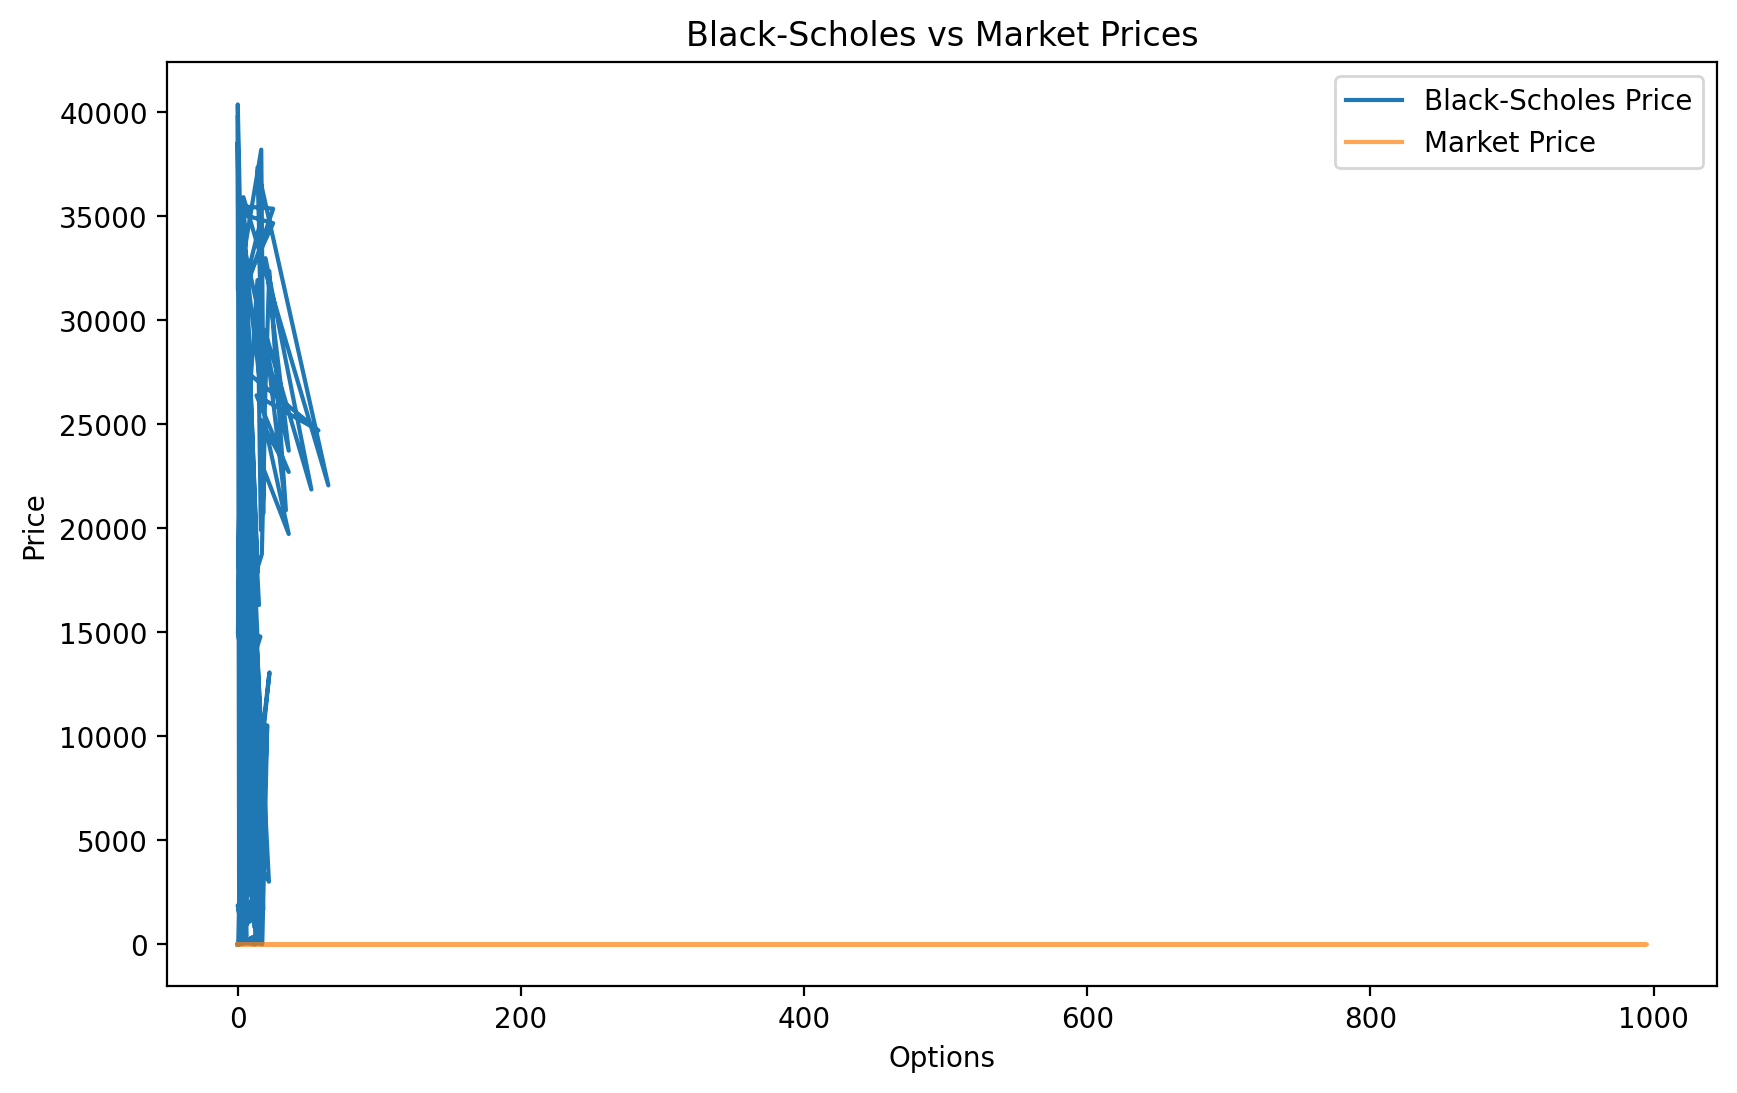

In [41]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


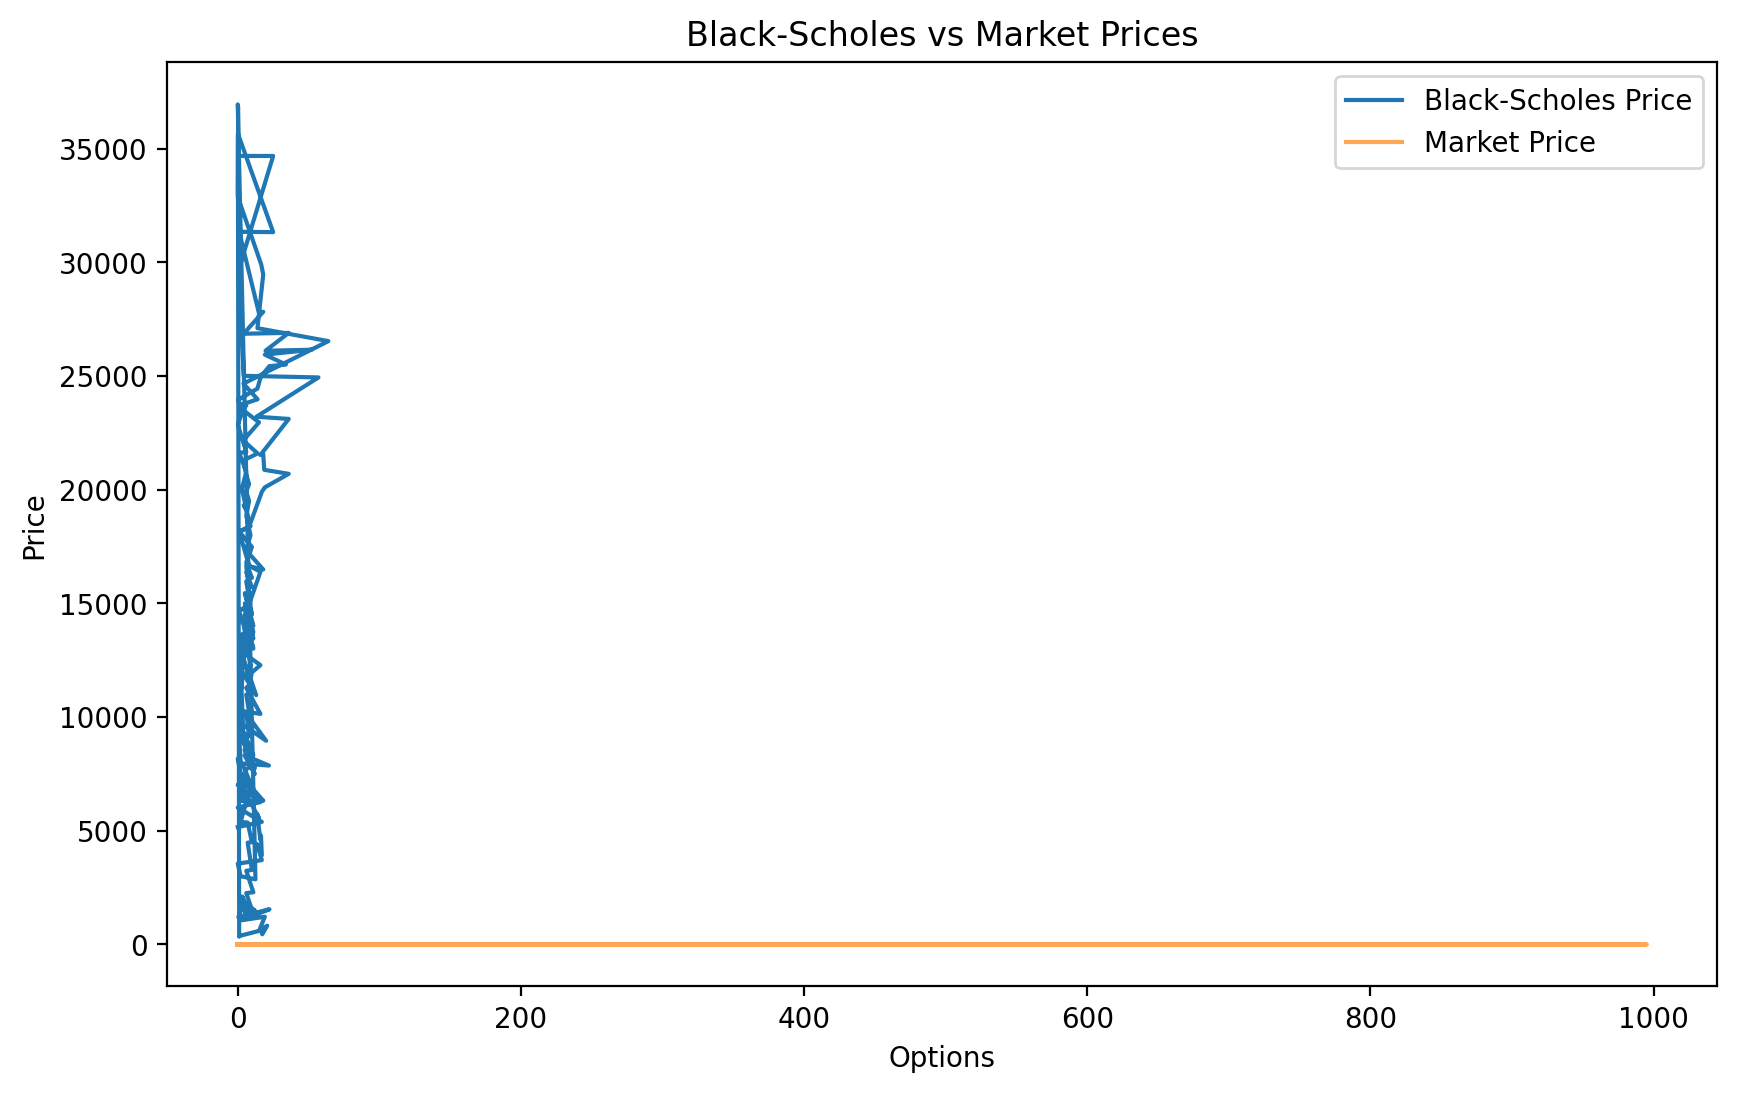

In [42]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price_1'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


In [43]:
# Example: Calibrating volatility
from scipy.optimize import minimize

def mse(x, market_prices, S, K, T, r):
    sigma = x
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return ((market_prices - estimated_prices) ** 2).mean()

initial_guess = 0.5
result = minimize(mse, initial_guess, args=(df['Market Price'].values, df['underlying_price'].values, df['Strike Price'].values, df['Time to Expiration'].values, risk_free_rate))
optimal_sigma = result.x


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


In [44]:
from scipy.optimize import minimize

# Define the Black-Scholes call pricing function
from scipy.stats import norm
import numpy as np

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate mean squared error between theoretical and market prices
def mse(sigma, market_prices, S, K, T, r):
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return np.mean((np.array(market_prices) - np.array(estimated_prices)) ** 2)

# Example data preparation: Assume df contains the relevant data
market_prices = df['Market Price'].values
underlying_prices = df['underlying_price'].values
strike_prices = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
risk_free_rate = 0.02  # Example rate, adjust according to your needs

# Optimize for the best sigma (volatility) using minimize
initial_guess = 0.5  # Initial guess for volatility
result = minimize(mse, initial_guess, args=(market_prices, underlying_prices, strike_prices, times_to_expiration, risk_free_rate))
optimal_sigma = result.x[0]

print(f"The optimal volatility (sigma) is: {optimal_sigma}")


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2683938550.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2683938550.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


The optimal volatility (sigma) is: 0.5


In [45]:
from scipy.stats import norm
import numpy as np
# Assuming you have already obtained the optimal volatility
sigma = 0.5  # Extract the optimal volatility value



# Define a safe version of the Black-Scholes Call pricing function
def black_scholes_call_safe(S, K, T, r, sigma):
    # Ensure parameters are within valid ranges
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return np.nan  # Return NaN if any parameter is invalid
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)



In [46]:
# Check for missing or zero values in relevant columns
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].isnull().sum())
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].min())


underlying_price      0
Strike Price          0
Time to Expiration    0
dtype: int64
underlying_price      43045.742600
Strike Price          10000.000000
Time to Expiration       -0.252055
dtype: float64


##### Filter out rows with zero or negative values in critical columns
##### Drop rows where Market Price is Null

In [47]:
# Filter out rows with zero or negative values in critical columns
df_clean = df[(df['underlying_price'] > 0) & (df['Strike Price'] > 0) & (df['Time to Expiration'] > 0)]

# Drop rows where Market Price is NaN to ensure the comparison is valid
# Alternatively, fill missing market prices with a default value or impute them
df_clean['Market Price'].fillna(df_clean['Market Price'].median(), inplace=True)
df_clean = df_clean.dropna(subset=['Market Price'])


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_13112\2398533704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Market Price'].fillna(df_clean['Market Price'].median(), inplace=True)


#### Apply Black-Scholes function 

In [48]:
# Apply the safe Black-Scholes function to the cleaned DataFrame
df_clean['Theoretical Price'] = df_clean.apply(lambda x: black_scholes_call_safe(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, optimal_sigma), axis=1)

# Check the results for the cleaned data
print(df_clean[['Market Price', 'Theoretical Price']].head())


                 Market Price  Theoretical Price
best_bid_amount                                 
1.1                    0.7610       34680.028967
25.0                   0.0009       34680.028967
1.0                    0.6600       29695.198455
1.0                    0.0013       29695.198455
4.2                    0.5385       24709.712136


### QuantLib

In [49]:
import QuantLib as ql


In [52]:
df = df_clean 

In [53]:
# Calculation date (today's date)
calculation_date = ql.Date(5, 5, 2024)
ql.Settings.instance().evaluationDate = calculation_date

# Market environment setup (replace with the actual values)
risk_free_rate = 0.02  # Example risk-free rate
rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, ql.Actual365Fixed()))

# Function to infer option type from the instrument name
def infer_option_type(instrument_name):
    return ql.Option.Call if instrument_name.endswith('-C') else ql.Option.Put

# Function to price each option using QuantLib, inferring the option type
def quantlib_price_option(row):
    # Extract relevant data
    S = row['underlying_price']
    K = row['Strike Price']
    T_expiration = row['Expiration Date']
    implied_vol = row['Implied Volatility']
    option_type = infer_option_type(row['instrument_name'])

    # Set up the exercise date and payoff
    maturity_date = ql.Date(T_expiration.day, T_expiration.month, T_expiration.year)
    payoff = ql.PlainVanillaPayoff(option_type, K)
    exercise = ql.EuropeanExercise(maturity_date)

    # Spot price and volatility setup
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, ql.NullCalendar(), implied_vol, ql.Actual365Fixed()))

    # Black-Scholes-Merton process
    bsm_process = ql.BlackScholesProcess(spot_handle, rate_handle, volatility_handle)

    # Set up the pricing engine using the BSM process
    pricing_engine = ql.AnalyticEuropeanEngine(bsm_process)

    # Create and price the European option
    european_option = ql.VanillaOption(payoff, exercise)
    european_option.setPricingEngine(pricing_engine)

    # Return the theoretical price
    return european_option.NPV()

# Apply the pricing function across the DataFrame
df['BS Price QuantLib'] = df.apply(quantlib_price_option, axis=1)

In [54]:
df[['underlying_price', 'Strike Price', 'Expiration Date', 'instrument_name', 'BS Price QuantLib']]


,underlying_price,Strike Price,Expiration Date,instrument_name,BS Price QuantLib
best_bid_amount,,,,,
1.1,44651.03,10000,2024-06-28,BTC-28JUN24-10000-C,35158.971046
25.0,44651.03,10000,2024-06-28,BTC-28JUN24-10000-P,0.045183
1.0,44651.70,15000,2024-06-28,BTC-28JUN24-15000-C,31163.955998
1.0,44651.70,15000,2024-06-28,BTC-28JUN24-15000-P,0.131164
4.2,44651.70,20000,2024-06-28,BTC-28JUN24-20000-C,27711.324927
...,...,...,...,...,...
0.0,46185.06,110000,2024-12-27,BTC-27DEC24-110000-P,62401.632042
16.0,46185.06,120000,2024-12-27,BTC-27DEC24-120000-C,520.251389
0.0,46185.06,120000,2024-12-27,BTC-27DEC24-120000-P,72273.149501
